In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from eli5.sklearn import PermutationImportance
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, learning_curve

In [4]:
df = pd.read_csv('Data.csv')
df.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,...,1,91,29.0,NaN,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,...,1,210,31.0,NaN,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,...,0,161,37.0,NaN,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,...,0,103,21.0,NaN,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,...,1,112,25.0,2009.0,18,0,C,6,24,24071


In [5]:
df.dropna(axis=0, inplace=True)

In [6]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
for col in cat_cols:
    encoder = LabelEncoder()
    df.loc[:, col] = encoder.fit_transform(df[col])

In [7]:
def create_folds(data):
    data['kfold'] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:, 'product_wg_ton_binned'] = pd.cut(data['product_wg_ton'], bins=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=5)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.product_wg_ton_binned.values)):
        data.loc[v_, 'kfold'] = f
    data = data.drop('product_wg_ton_binned', axis=1)
    data.to_csv('train_folds.csv', index=False)
    return data

df = create_folds(df)

In [8]:
df.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton,kfold
0,10139,10139,0,1,1,1,8,0,4,4378,...,218,23.0,2006.0,36,1,1,6,12,51148,0
1,6762,6762,0,0,1,5,5,3,3,4959,...,55,14.0,1998.0,24,1,2,6,28,28117,0
2,7968,7968,0,1,3,3,7,0,2,4913,...,235,39.0,2018.0,9,0,0,6,11,12124,0
3,6708,6708,0,1,3,3,4,0,5,4954,...,142,30.0,2010.0,15,0,0,2,11,21098,0
4,10329,10329,0,2,3,5,8,0,2,5973,...,247,27.0,2000.0,37,1,1,3,9,49097,0


In [9]:
df['kfold'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
import xgboost as xgb
import lightgbm as lgm

models = {
    'ridge': linear_model.Ridge(),
    'lasso': linear_model.Lasso(),
    'decision_tree': tree.DecisionTreeRegressor(),
    'random_forest': ensemble.RandomForestRegressor(),
    'linear_reg': linear_model.LinearRegression(),
    'etr': ensemble.ExtraTreesRegressor(),
    'gbr': ensemble.GradientBoostingRegressor(),
    'hgbr': ensemble.HistGradientBoostingRegressor(),
    'abr': ensemble.AdaBoostRegressor(),
    'xgb_regressor': xgb.XGBRegressor(),
    'lgm': lgm.LGBMRegressor()
}

In [11]:
import pandas as pd
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler


def run(fold, model, model_type):
    if model_type == 'tree':
        df = pd.read_csv('train_folds.csv')

        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        x_train = df_train.drop('product_wg_ton', axis=1).values
        y_train = df_train.product_wg_ton.values
        x_valid = df_valid.drop('product_wg_ton', axis=1).values
        y_valid = df_valid.product_wg_ton.values

        reg = models[model]
        reg.fit(x_train, y_train)
        preds = reg.predict(x_valid)

        mae = metrics.mean_absolute_error(y_valid, preds)
        mse = metrics.mean_squared_error(y_valid, preds)
        rmse = metrics.mean_squared_error(y_valid, preds, squared=False)
        r2 = metrics.r2_score(y_valid, preds)
        print(f"Fold={fold}, Mean Squared Error={mse}, Mean Absolute Error={mae}, Root Mean Squared Error={rmse}, Squared={r2}", end="\n")

    else:
        df = pd.read_csv('train_folds.csv')

        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        x_train = df_train.drop('product_wg_ton', axis=1).values
        y_train = df_train.product_wg_ton.values
        x_valid = df_valid.drop('product_wg_ton', axis=1).values
        y_valid = df_valid.product_wg_ton.values

        reg = models[model]
        pipeline = Pipeline([('scaler', RobustScaler()), ('model', reg)])
        pipeline.fit(x_train, y_train)
        preds = pipeline.predict(x_valid)
        
        mae = metrics.mean_absolute_error(y_valid, preds)
        mse = metrics.mean_squared_error(y_valid, preds)
        rmse = metrics.mean_squared_error(y_valid, preds, squared=False)
        r2 = metrics.r2_score(y_valid, preds)
        print(f"Fold={fold}, Mean Squared Error={mse}, Mean Absolute Error={mae}, Root Mean Squared Error={rmse}, Squared={r2}", end="\n")

In [50]:
for i in range(0, 5, 1):
    run(i, 'ridge', 'linear')

Fold=0, Mean Squared Error=2102870.563795005, Mean Absolute Error=1152.5939575201603, Root Mean Squared Error=1450.1277749891576, Squared=0.9843104034055477
Fold=1, Mean Squared Error=2030316.4169194857, Mean Absolute Error=1118.6573499858432, Root Mean Squared Error=1424.8917211211124, Squared=0.9848509360373399
Fold=2, Mean Squared Error=2138440.300161752, Mean Absolute Error=1155.5709256470132, Root Mean Squared Error=1462.3406922334316, Squared=0.9840499270543506
Fold=3, Mean Squared Error=2027538.4132080723, Mean Absolute Error=1125.2842215210271, Root Mean Squared Error=1423.9165752276615, Squared=0.9848463826153305
Fold=4, Mean Squared Error=2070928.27667816, Mean Absolute Error=1137.3414196065692, Root Mean Squared Error=1439.0720192812312, Squared=0.9844891213700782


In [54]:
for i in range(0, 5, 1):
    run(i, 'xgb_regressor', 'tree')

Fold=0, Mean Squared Error=781114.7892641663, Mean Absolute Error=687.3211713194945, Root Mean Squared Error=883.806986430955, Squared=0.9941720730945045
Fold=1, Mean Squared Error=744428.5065736616, Mean Absolute Error=673.8318346091173, Root Mean Squared Error=862.8027043152226, Squared=0.9944454987568772
Fold=2, Mean Squared Error=786693.5920081699, Mean Absolute Error=694.2956447326031, Root Mean Squared Error=886.9574916579542, Squared=0.9941322560290993
Fold=3, Mean Squared Error=754229.8163813022, Mean Absolute Error=681.1806360744201, Root Mean Squared Error=868.4640558948322, Squared=0.9943629625051258
Fold=4, Mean Squared Error=783540.4993677093, Mean Absolute Error=694.7936209326675, Root Mean Squared Error=885.1782302834324, Squared=0.9941314232249436


In [55]:
for i in range(0, 5, 1):
    run(i, 'lgm', 'tree')

Fold=0, Mean Squared Error=710684.4919504182, Mean Absolute Error=656.3348227403317, Root Mean Squared Error=843.021050716065, Squared=0.9946975561993161
Fold=1, Mean Squared Error=693349.936570906, Mean Absolute Error=646.4673185026217, Root Mean Squared Error=832.6763696484403, Squared=0.9948266179349741
Fold=2, Mean Squared Error=696785.2554749644, Mean Absolute Error=651.3089306384337, Root Mean Squared Error=834.7366383925917, Squared=0.9948028590503846
Fold=3, Mean Squared Error=682134.288336381, Mean Absolute Error=643.5433947964741, Root Mean Squared Error=825.914213666517, Squared=0.9949017972024224
Fold=4, Mean Squared Error=696207.1834591881, Mean Absolute Error=658.7298714098066, Root Mean Squared Error=834.3903064269072, Squared=0.99478553398226


In [56]:
for i in range(0, 5, 1):
    run(i, 'decision_tree', 'tree')

Fold=0, Mean Squared Error=1438038.6335531739, Mean Absolute Error=856.5346248969497, Root Mean Squared Error=1199.18248550968, Squared=0.9892707395138153
Fold=1, Mean Squared Error=1449084.4530090685, Mean Absolute Error=840.0193734542456, Root Mean Squared Error=1203.7792376549235, Squared=0.9891877576898885
Fold=2, Mean Squared Error=1483386.5575257733, Mean Absolute Error=858.160824742268, Root Mean Squared Error=1217.9435773161963, Squared=0.9889358034463986
Fold=3, Mean Squared Error=1533601.006185567, Mean Absolute Error=864.6870103092783, Root Mean Squared Error=1238.386452681701, Squared=0.9885380209237519
Fold=4, Mean Squared Error=1510140.5612371133, Mean Absolute Error=859.8032989690722, Root Mean Squared Error=1228.8777649697765, Squared=0.9886893200391067


In [10]:
for i in range(0, 5, 1):
    run(i, 'random_forest', 'tree')

Fold=0, Mean Squared Error=776430.9420371393, Mean Absolute Error=682.2849422918384, Root Mean Squared Error=881.1531887459406, Squared=0.9942040784109908
Fold=1, Mean Squared Error=821347.2408007833, Mean Absolute Error=696.9603173948886, Root Mean Squared Error=906.2820978044216, Squared=0.9938795350615965
Fold=2, Mean Squared Error=784595.5284371545, Mean Absolute Error=683.0182639175257, Root Mean Squared Error=885.7739714154816, Squared=0.9941605837817502
Fold=3, Mean Squared Error=800883.3172325362, Mean Absolute Error=689.1404907216495, Root Mean Squared Error=894.9208441155766, Squared=0.9939897734695455
Fold=4, Mean Squared Error=785153.0599092372, Mean Absolute Error=682.448268041237, Root Mean Squared Error=886.0886298273086, Squared=0.9941257462963501


In [58]:
for i in range(0, 5, 1):
    run(i, 'etr', 'tree')

Fold=0, Mean Squared Error=807586.0736105524, Mean Absolute Error=692.8923000824402, Root Mean Squared Error=898.6579291424254, Squared=0.9939745698435282
Fold=1, Mean Squared Error=814935.2008350784, Mean Absolute Error=697.8435572959604, Root Mean Squared Error=902.7376146118419, Squared=0.9939194179882537
Fold=2, Mean Squared Error=816977.5925593403, Mean Absolute Error=699.8913402061855, Root Mean Squared Error=903.8681278590037, Squared=0.9939063755040078
Fold=3, Mean Squared Error=806964.5543275464, Mean Absolute Error=688.9231298969072, Root Mean Squared Error=898.3120584337863, Squared=0.9939688283982144
Fold=4, Mean Squared Error=836912.9163942268, Mean Absolute Error=709.6056742268041, Root Mean Squared Error=914.8294466151748, Squared=0.9937316734644103


In [59]:
for i in range(0, 5, 1):
    run(i, 'gbr', 'tree')

Fold=0, Mean Squared Error=726649.6377243054, Mean Absolute Error=673.5241101387044, Root Mean Squared Error=852.4374685126795, Squared=0.9945784396445093
Fold=1, Mean Squared Error=732752.2525730828, Mean Absolute Error=673.4226075559194, Root Mean Squared Error=856.0094932727574, Squared=0.9945326203095697
Fold=2, Mean Squared Error=738542.8333384179, Mean Absolute Error=683.5415332959084, Root Mean Squared Error=859.385148427885, Squared=0.9944914000805432
Fold=3, Mean Squared Error=698996.7822890304, Mean Absolute Error=664.4114448070403, Root Mean Squared Error=836.0602743158117, Squared=0.9947757686251856
Fold=4, Mean Squared Error=726731.5805829288, Mean Absolute Error=680.2095983244824, Root Mean Squared Error=852.4855310108957, Squared=0.9945569117627607


In [60]:
for i in range(0, 5, 1):
    run(i, 'hgbr', 'tree')

Fold=0, Mean Squared Error=710914.6092516055, Mean Absolute Error=656.5150081853179, Root Mean Squared Error=843.1575233914512, Squared=0.9946958392854522
Fold=1, Mean Squared Error=691648.0896481702, Mean Absolute Error=645.9385086179574, Root Mean Squared Error=831.6538280126955, Squared=0.9948393161467761
Fold=2, Mean Squared Error=701747.0368201729, Mean Absolute Error=653.3192539078639, Root Mean Squared Error=837.7034301112614, Squared=0.9947658504070334
Fold=3, Mean Squared Error=681209.9839052847, Mean Absolute Error=642.6854363659983, Root Mean Squared Error=825.3544595537633, Squared=0.9949087053604158
Fold=4, Mean Squared Error=697580.3682693082, Mean Absolute Error=656.920493588132, Root Mean Squared Error=835.2127682628591, Squared=0.9947752490761307


In [61]:
for i in range(0, 5, 1):
    run(i, 'abr', 'tree')

Fold=0, Mean Squared Error=2525608.480065915, Mean Absolute Error=1293.6516327260797, Root Mean Squared Error=1589.2163100301716, Squared=0.9811563398670385
Fold=1, Mean Squared Error=2365246.520343389, Mean Absolute Error=1228.4297842498218, Root Mean Squared Error=1537.9357985115598, Squared=0.9823518784926605
Fold=2, Mean Squared Error=2595196.822062499, Mean Absolute Error=1292.8403897084306, Root Mean Squared Error=1610.9614589003982, Squared=0.9806430983286822
Fold=3, Mean Squared Error=2362146.849141933, Mean Absolute Error=1242.5205144216807, Root Mean Squared Error=1536.9277306177844, Squared=0.982345552949765
Fold=4, Mean Squared Error=2582273.0740634636, Mean Absolute Error=1303.2572602197047, Root Mean Squared Error=1606.9452616886065, Squared=0.9806592412242493


In [94]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.1, max_depth=5)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.994938577457117
Mean Absolute Error=647.2894133137753
Mean Squared Error=692064.2603286367
Root Mean Squared Error=831.9039970625437


In [15]:
X.columns

Index(['Location_type', 'WH_capacity_size', 'zone', 'WH_regional_zone',
       'num_refill_req_l3m', 'transport_issue_l1y', 'Competitor_in_mkt',
       'retail_shop_num', 'wh_owner_type', 'distributor_num', 'flood_impacted',
       'flood_proof', 'electric_supply', 'dist_from_hub', 'workers_num',
       'wh_est_year', 'storage_issue_reported_l3m', 'temp_reg_mach',
       'approved_wh_govt_certificate', 'wh_breakdown_l3m', 'govt_check_l3m'],
      dtype='object')

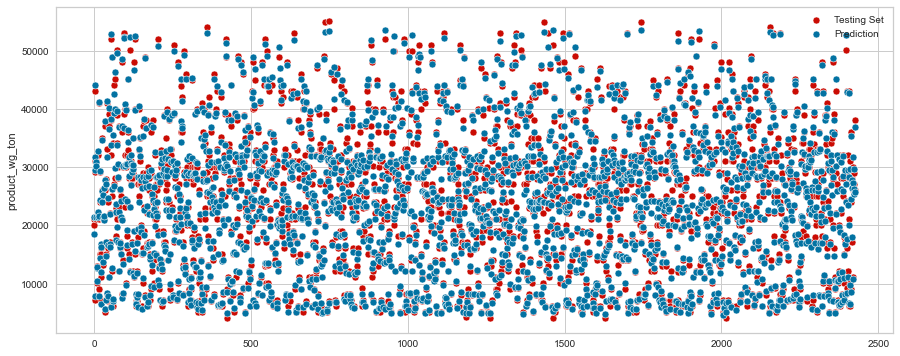

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x=np.arange(len(y_test)), y=y_test, label='Testing Set', color='r', ax=ax)
sns.scatterplot(x=np.arange(len(preds)), y=preds, label='Prediction', ax=ax)
plt.legend(loc='best')
plt.show()

In [17]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

reg = xgb.XGBRegressor(eta=0.07, max_depth=5)
train_sizes, train_scores, test_scores = learning_curve(reg, X, y, 
                                                        cv=10, scoring='neg_mean_squared_error', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

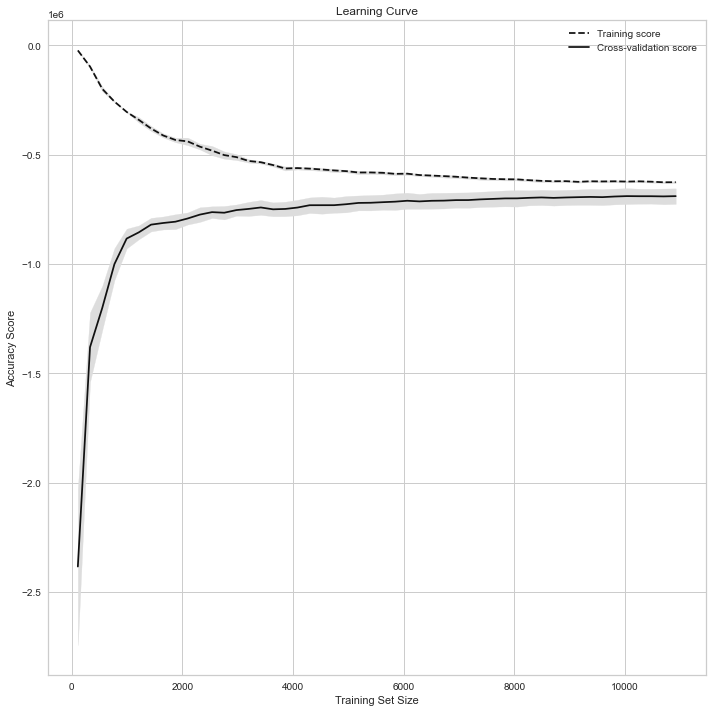

In [18]:
plt.subplots(1, figsize=(10, 10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

<Figure size 1080x432 with 0 Axes>

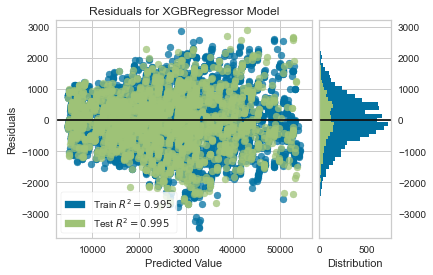

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [95]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.07, max_depth=5)

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

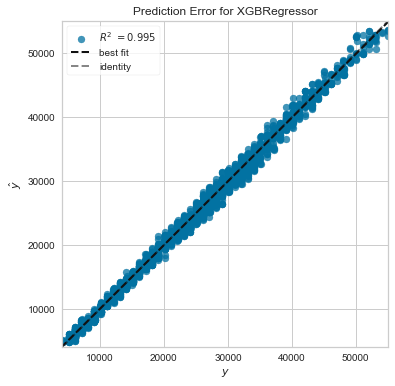

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [21]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = xgb.XGBRegressor(eta=0.07, max_depth=5)

visualizer = PredictionError(reg)

plt.figure(figsize=(15, 6))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

<AxesSubplot:>

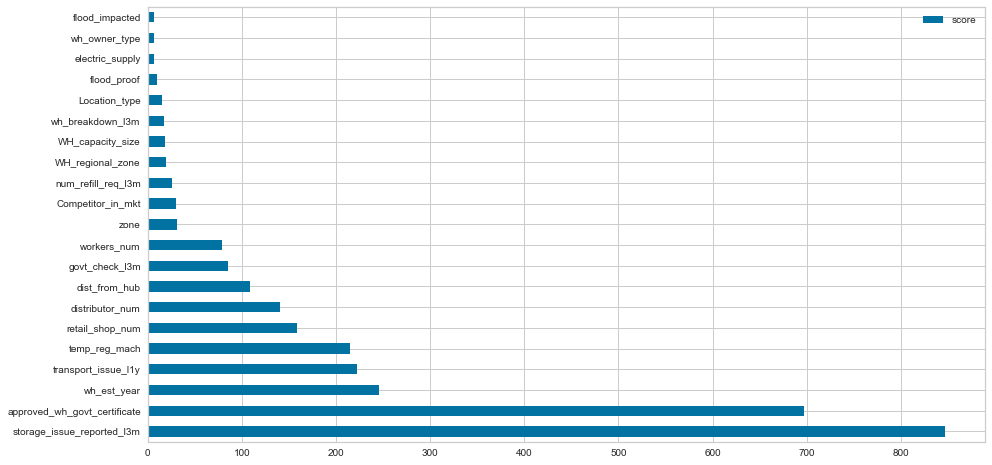

In [22]:
feature_important = reg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(X.columns), columns="score").plot(kind='barh', figsize = (15, 8))

In [25]:
perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
2.0115 ± 0.0390,storage_issue_reported_l3m
0.0193 ± 0.0006,approved_wh_govt_certificate
0.0028 ± 0.0002,wh_est_year
0.0023 ± 0.0001,temp_reg_mach
0.0016 ± 0.0001,transport_issue_l1y
0.0001 ± 0.0000,retail_shop_num
0.0001 ± 0.0000,distributor_num
0.0001 ± 0.0000,dist_from_hub
0.0000 ± 0.0000,govt_check_l3m
0.0000 ± 0.0000,workers_num


In [56]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

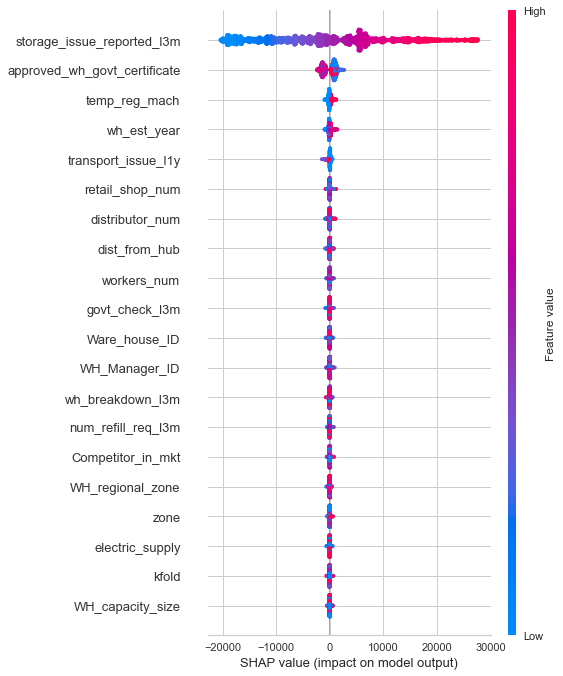

In [57]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

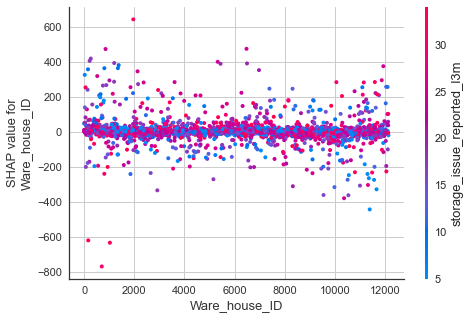

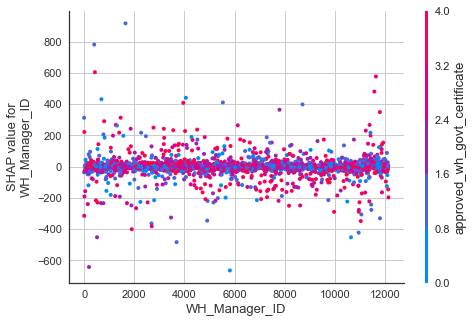

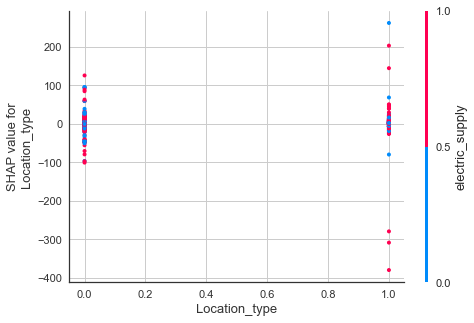

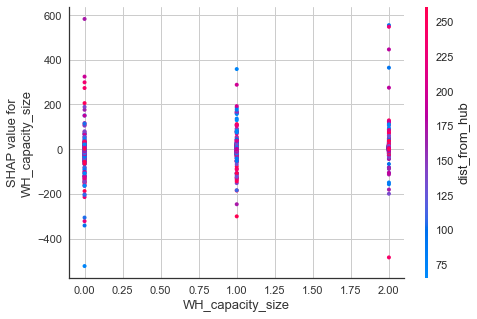

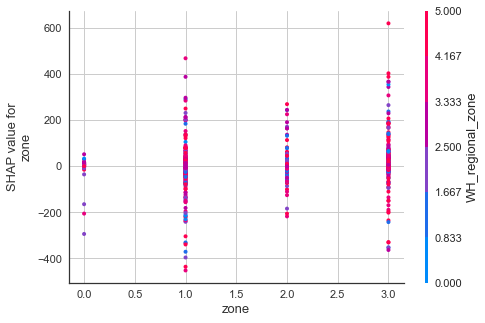

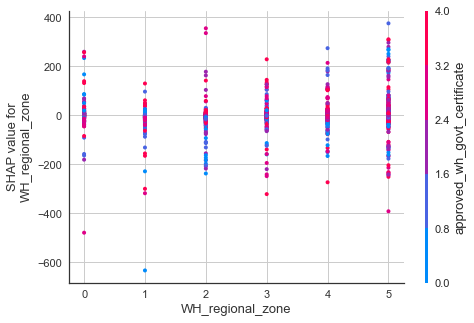

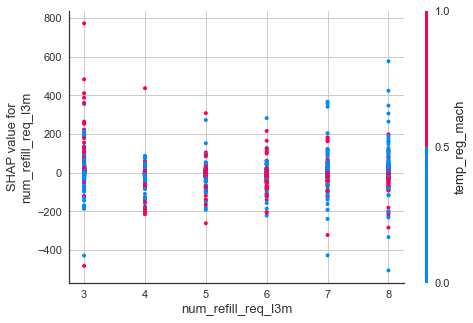

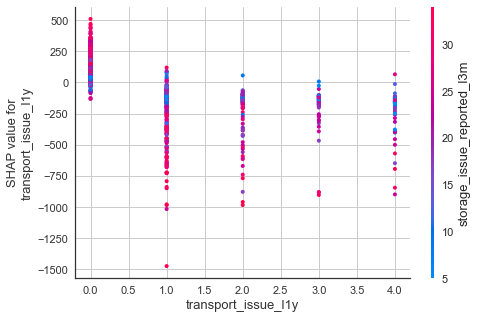

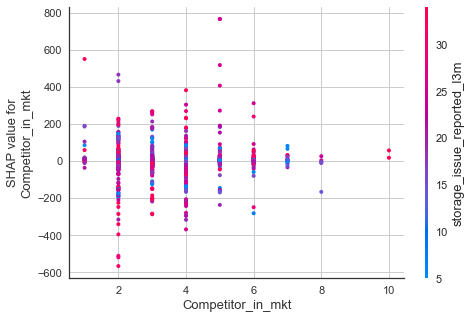

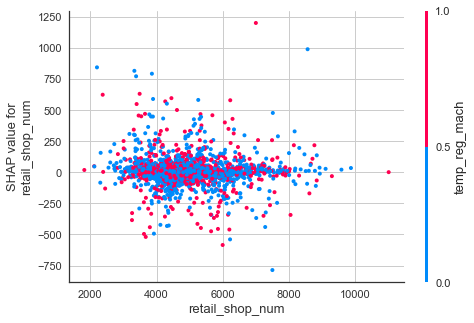

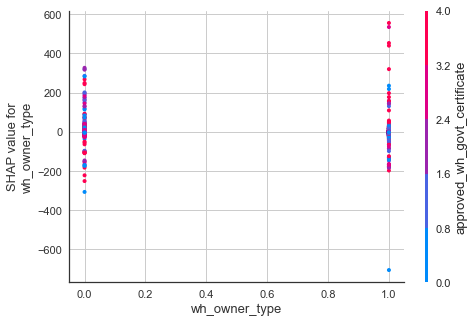

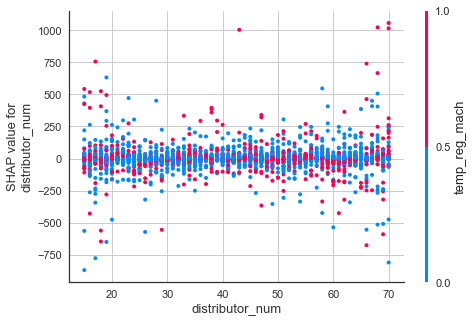

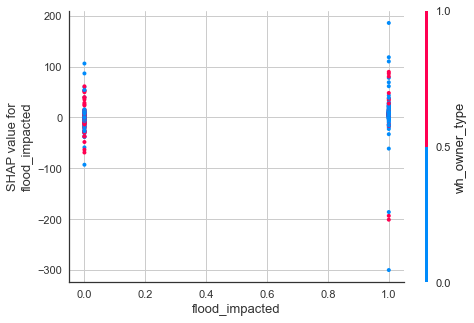

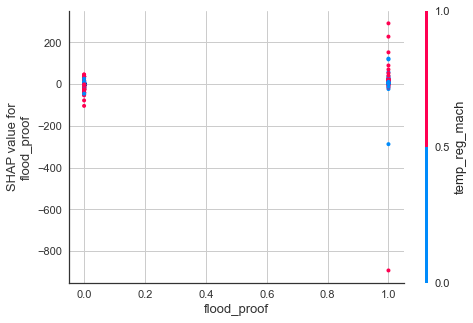

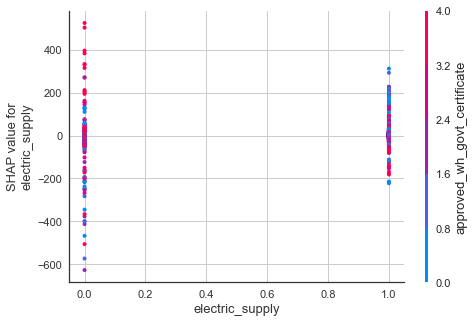

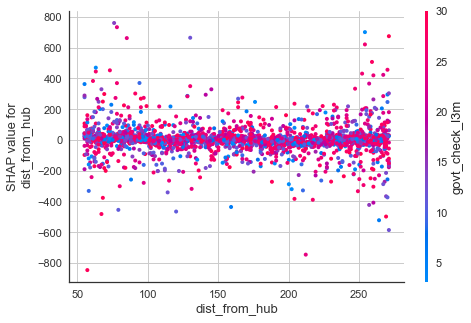

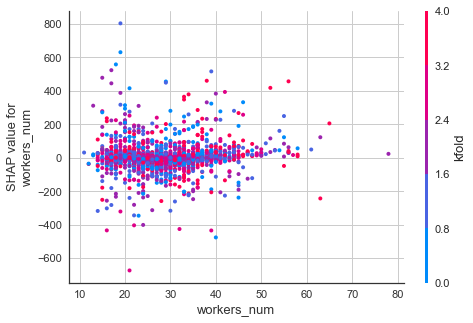

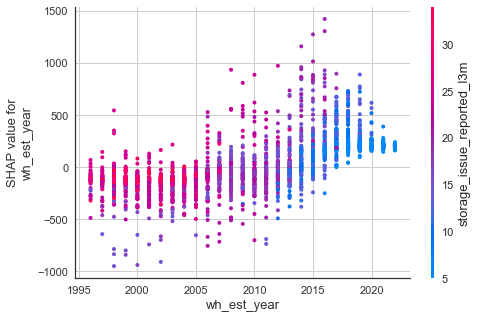

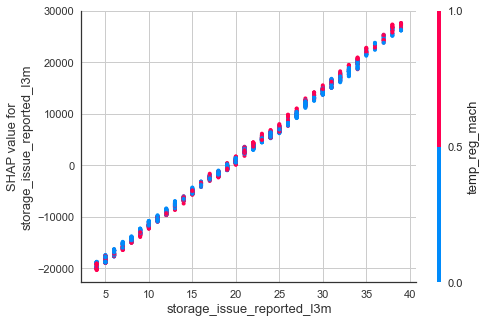

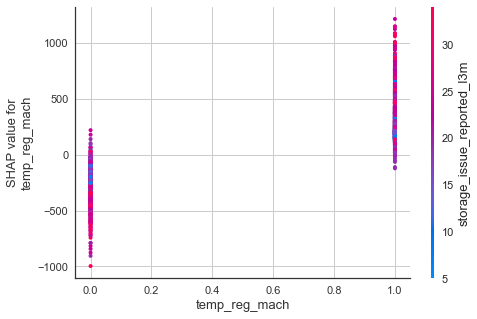

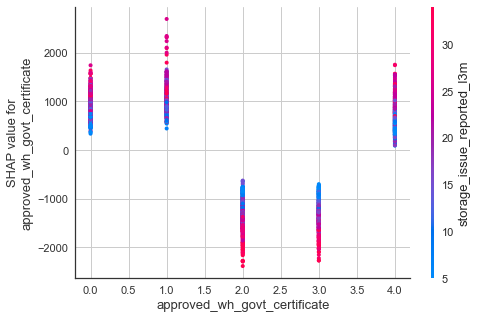

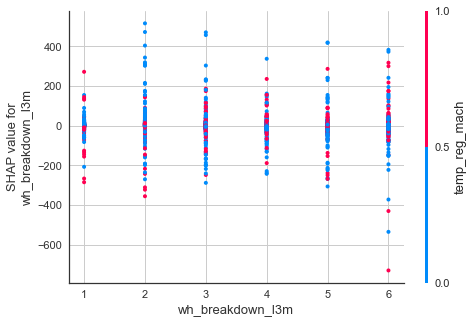

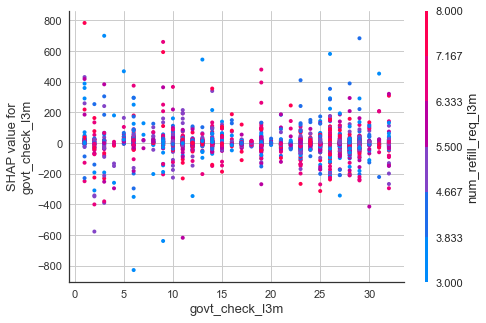

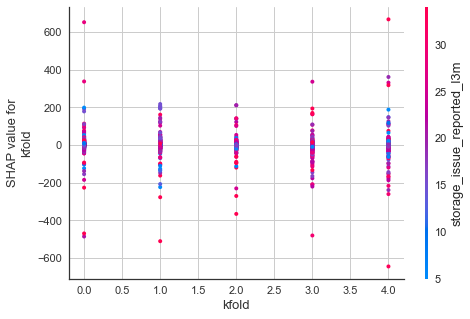

In [82]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [100]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

regressor = xgb.XGBRegressor()
param_grid = {
    'eta': [0.1, 0.3, 0.5, 0.7, 0.9, 0.01, 0.03, 0.05, 0.07, 0.09],
    'max_depth': [3, 5, 7, 9, 11],
    'colsample_bytree': [0.9],
    'colsample_bylevel': [0.9],
    'colsample_bynode': [0.9],
    'subsample': [0.9]
    
}
model = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    verbose=10,
    n_jobs=1,
    cv=3
)
model.fit(X, y)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9
[CV 1/3; 1/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9;, score=-846586.819 total time=   0.1s
[CV 2/3; 1/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9
[CV 2/3; 1/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9;, score=-820564.053 total time=   0.1s
[CV 3/3; 1/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9
[CV 3/3; 1/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.1, max_depth=3, subsample=0.9;, score=-835654.130 total time=   0.1s
[CV 1/3; 2/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=

[CV 3/3; 10/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.3, max_depth=11, subsample=0.9;, score=-928377.982 total time=   1.1s
[CV 1/3; 11/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9
[CV 1/3; 11/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9;, score=-834095.337 total time=   0.2s
[CV 2/3; 11/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9
[CV 2/3; 11/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9;, score=-756354.675 total time=   0.2s
[CV 3/3; 11/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9
[CV 3/3; 11/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.5, max_depth=3, subsample=0.9;, score=-806720

[CV 2/3; 20/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.7, max_depth=11, subsample=0.9;, score=-1135243.966 total time=   1.2s
[CV 3/3; 20/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.7, max_depth=11, subsample=0.9
[CV 3/3; 20/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.7, max_depth=11, subsample=0.9;, score=-1156023.968 total time=   1.2s
[CV 1/3; 21/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.9, max_depth=3, subsample=0.9
[CV 1/3; 21/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.9, max_depth=3, subsample=0.9;, score=-888001.916 total time=   0.2s
[CV 2/3; 21/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.9, max_depth=3, subsample=0.9
[CV 2/3; 21/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.9, max_depth=3, subsample=0.9;, score=-86

[CV 1/3; 30/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.01, max_depth=11, subsample=0.9;, score=-101485073.798 total time=   0.4s
[CV 2/3; 30/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.01, max_depth=11, subsample=0.9
[CV 2/3; 30/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.01, max_depth=11, subsample=0.9;, score=-102598138.208 total time=   0.5s
[CV 3/3; 30/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.01, max_depth=11, subsample=0.9
[CV 3/3; 30/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.01, max_depth=11, subsample=0.9;, score=-105871775.770 total time=   0.5s
[CV 1/3; 31/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.03, max_depth=3, subsample=0.9
[CV 1/3; 31/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.03, max_depth=3, subsample

[CV 3/3; 39/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=9, subsample=0.9;, score=-904170.318 total time=   0.7s
[CV 1/3; 40/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9
[CV 1/3; 40/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9;, score=-888475.793 total time=   0.9s
[CV 2/3; 40/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9
[CV 2/3; 40/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9;, score=-910291.919 total time=   0.9s
[CV 3/3; 40/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9
[CV 3/3; 40/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.05, max_depth=11, subsample=0.9;, s

[CV 2/3; 49/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=9, subsample=0.9;, score=-790032.667 total time=   0.7s
[CV 3/3; 49/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=9, subsample=0.9
[CV 3/3; 49/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=9, subsample=0.9;, score=-841714.638 total time=   0.7s
[CV 1/3; 50/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=11, subsample=0.9
[CV 1/3; 50/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=11, subsample=0.9;, score=-880418.351 total time=   1.0s
[CV 2/3; 50/50] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=11, subsample=0.9
[CV 2/3; 50/50] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, eta=0.09, max_depth=11, subsample=0.9;, sco

In [103]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = lgm.LGBMRegressor(num_leaves=100, eta=0.1, max_depth=5)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.9948627909968106
Mean Absolute Error=650.5095244600966
Mean Squared Error=702426.7819617342
Root Mean Squared Error=838.1090513541386


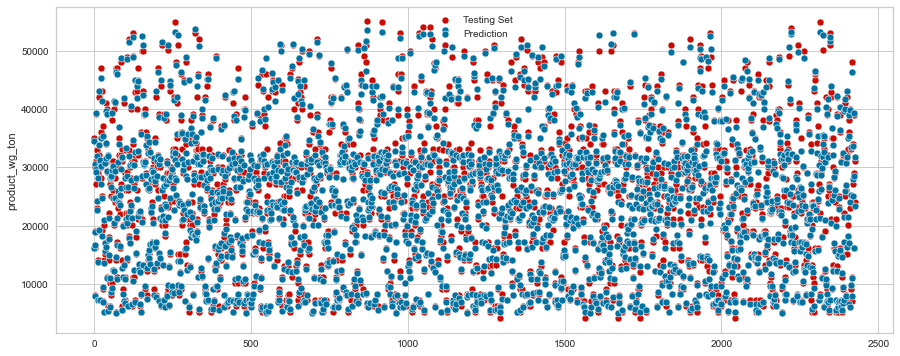

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x=np.arange(len(y_test)), y=y_test, label='Testing Set', color='r', ax=ax)
sns.scatterplot(x=np.arange(len(preds)), y=preds, label='Prediction', ax=ax)
plt.legend(loc='best')
plt.show()

In [41]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

reg = lgm.LGBMRegressor()
train_sizes, train_scores, test_scores = learning_curve(reg, X, y, 
                                                        cv=10, scoring='neg_mean_squared_error', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

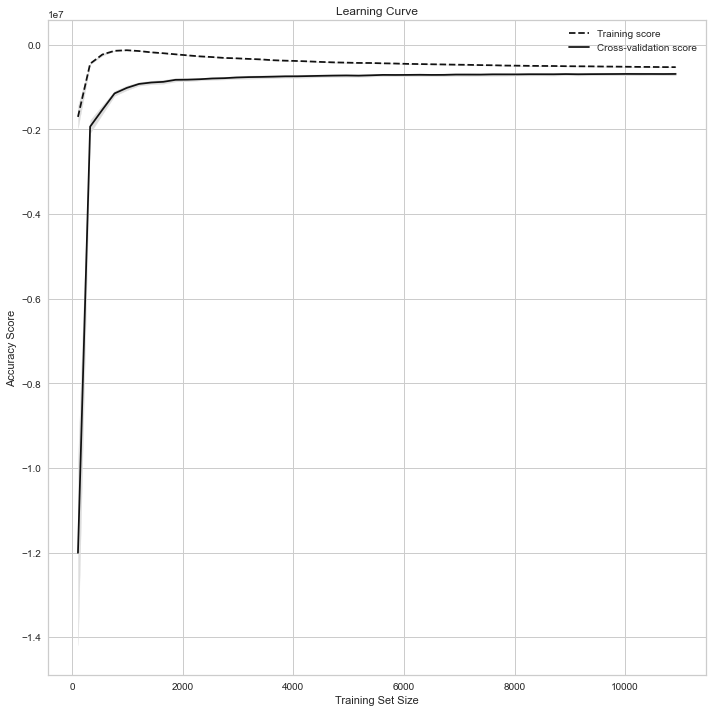

In [42]:
plt.subplots(1, figsize=(10, 10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

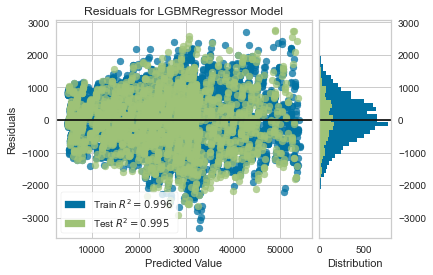

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = lgm.LGBMRegressor()

visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

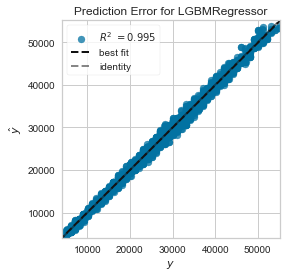

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [44]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = lgm.LGBMRegressor()

visualizer = PredictionError(reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

In [97]:
boost = reg.booster_
features = boost.feature_name()
data = pd.DataFrame(data=features)
data

,0
0,Ware_house_ID
1,WH_Manager_ID
2,Location_type
3,WH_capacity_size
4,zone
5,WH_regional_zone
6,num_refill_req_l3m
7,transport_issue_l1y
8,Competitor_in_mkt
9,retail_shop_num


In [102]:
X = df.drop(['product_wg_ton', 'kfold', 'Ware_house_ID', 'WH_Manager_ID'], axis=1)
y = df['product_wg_ton']

reg = lgm.LGBMRegressor()
param_grid = {
    'eta': [0.1, 0.3, 0.5, 0.7, 0.9, 0.01, 0.03, 0.05, 0.07, 0.09],
    'max_depth': [3, 5, 7, 9, 11],
    'num_leaves': [100, 500, 1000, 2000, 5000]
    
}
model = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    verbose=10,
    n_jobs=1,
    cv=3
)
model.fit(X, y)
print(f"Best score: {model.best_score_}")
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV 1/3; 1/250] START eta=0.1, max_depth=3, num_leaves=100......................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 1/250] END eta=0.1, max_depth=3, num_leaves=100;, score=-758523.665 total time=   0.0s
[CV 2/3; 1/250] START eta=0.1, max_depth=3, num_leaves=100......................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 1/250] END eta=0.1, max_depth=3, num_leaves=100;, score=-711897.951 total time=   0.0s
[CV 3/3; 1/250] START eta=0.1, max_depth=3, num_leaves=100......................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 1/250] END eta=0.1, max_depth=3, num_leaves=100;, score=-716978.343 total time=   0.0s
[CV 1/3; 2/250] START eta=0.1, max_depth=3, num_leaves=500......................
[LightGBM]

[CV 1/3; 11/250] END eta=0.1, max_depth=7, num_leaves=100;, score=-735716.711 total time=   0.1s
[CV 2/3; 11/250] START eta=0.1, max_depth=7, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 11/250] END eta=0.1, max_depth=7, num_leaves=100;, score=-691600.916 total time=   0.1s
[CV 3/3; 11/250] START eta=0.1, max_depth=7, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 11/250] END eta=0.1, max_depth=7, num_leaves=100;, score=-709671.784 total time=   0.1s
[CV 1/3; 12/250] START eta=0.1, max_depth=7, num_leaves=500.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 12/250] END eta=0.1, max_depth=7, num_leaves=500;, score=-737255.494 total time=   0.1s
[CV 2/3; 12/250] START eta=0.1, max_depth=7, num_leave

[CV 3/3; 20/250] END eta=0.1, max_depth=9, num_leaves=5000;, score=-759442.837 total time=   0.5s
[CV 1/3; 21/250] START eta=0.1, max_depth=11, num_leaves=100....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 21/250] END eta=0.1, max_depth=11, num_leaves=100;, score=-754753.542 total time=   0.3s
[CV 2/3; 21/250] START eta=0.1, max_depth=11, num_leaves=100....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 21/250] END eta=0.1, max_depth=11, num_leaves=100;, score=-722885.587 total time=   0.3s
[CV 3/3; 21/250] START eta=0.1, max_depth=11, num_leaves=100....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 21/250] END eta=0.1, max_depth=11, num_leaves=100;, score=-732304.413 total time=   0.3s
[CV 1/3; 22/250] START eta=0.1, max_depth=11, num_

[CV 1/3; 31/250] END eta=0.3, max_depth=5, num_leaves=100;, score=-720034.996 total time=   0.0s
[CV 2/3; 31/250] START eta=0.3, max_depth=5, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 31/250] END eta=0.3, max_depth=5, num_leaves=100;, score=-684857.701 total time=   0.0s
[CV 3/3; 31/250] START eta=0.3, max_depth=5, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 31/250] END eta=0.3, max_depth=5, num_leaves=100;, score=-689193.118 total time=   0.0s
[CV 1/3; 32/250] START eta=0.3, max_depth=5, num_leaves=500.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 32/250] END eta=0.3, max_depth=5, num_leaves=500;, score=-720034.996 total time=   0.0s
[CV 2/3; 32/250] START eta=0.3, max_depth=5, num_leave

[CV 3/3; 40/250] END eta=0.3, max_depth=7, num_leaves=5000;, score=-711051.853 total time=   0.1s
[CV 1/3; 41/250] START eta=0.3, max_depth=9, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 41/250] END eta=0.3, max_depth=9, num_leaves=100;, score=-757250.558 total time=   0.2s
[CV 2/3; 41/250] START eta=0.3, max_depth=9, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 41/250] END eta=0.3, max_depth=9, num_leaves=100;, score=-718872.672 total time=   0.2s
[CV 3/3; 41/250] START eta=0.3, max_depth=9, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 41/250] END eta=0.3, max_depth=9, num_leaves=100;, score=-727864.975 total time=   0.2s
[CV 1/3; 42/250] START eta=0.3, max_depth=9, num_leav

[CV 2/3; 50/250] END eta=0.3, max_depth=11, num_leaves=5000;, score=-752852.211 total time=   0.7s
[CV 3/3; 50/250] START eta=0.3, max_depth=11, num_leaves=5000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 50/250] END eta=0.3, max_depth=11, num_leaves=5000;, score=-774308.433 total time=   0.7s
[CV 1/3; 51/250] START eta=0.5, max_depth=3, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 51/250] END eta=0.5, max_depth=3, num_leaves=100;, score=-758523.665 total time=   0.0s
[CV 2/3; 51/250] START eta=0.5, max_depth=3, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 51/250] END eta=0.5, max_depth=3, num_leaves=100;, score=-711897.951 total time=   0.0s
[CV 3/3; 51/250] START eta=0.5, max_depth=3, num_l

[CV 2/3; 60/250] END eta=0.5, max_depth=5, num_leaves=5000;, score=-684857.701 total time=   0.0s
[CV 3/3; 60/250] START eta=0.5, max_depth=5, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 60/250] END eta=0.5, max_depth=5, num_leaves=5000;, score=-689193.118 total time=   0.0s
[CV 1/3; 61/250] START eta=0.5, max_depth=7, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 61/250] END eta=0.5, max_depth=7, num_leaves=100;, score=-735716.711 total time=   0.1s
[CV 2/3; 61/250] START eta=0.5, max_depth=7, num_leaves=100.....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 61/250] END eta=0.5, max_depth=7, num_leaves=100;, score=-691600.916 total time=   0.1s
[CV 3/3; 61/250] START eta=0.5, max_depth=7, num_lea

[CV 1/3; 70/250] END eta=0.5, max_depth=9, num_leaves=5000;, score=-783697.971 total time=   0.4s
[CV 2/3; 70/250] START eta=0.5, max_depth=9, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 70/250] END eta=0.5, max_depth=9, num_leaves=5000;, score=-725553.922 total time=   0.4s
[CV 3/3; 70/250] START eta=0.5, max_depth=9, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 70/250] END eta=0.5, max_depth=9, num_leaves=5000;, score=-759442.837 total time=   0.4s
[CV 1/3; 71/250] START eta=0.5, max_depth=11, num_leaves=100....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.5 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 71/250] END eta=0.5, max_depth=11, num_leaves=100;, score=-754753.542 total time=   0.3s
[CV 2/3; 71/250] START eta=0.5, max_depth=11, num_

[CV 3/3; 79/250] END eta=0.7, max_depth=3, num_leaves=2000;, score=-716978.343 total time=   0.0s
[CV 1/3; 80/250] START eta=0.7, max_depth=3, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 80/250] END eta=0.7, max_depth=3, num_leaves=5000;, score=-758523.665 total time=   0.0s
[CV 2/3; 80/250] START eta=0.7, max_depth=3, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 80/250] END eta=0.7, max_depth=3, num_leaves=5000;, score=-711897.951 total time=   0.0s
[CV 3/3; 80/250] START eta=0.7, max_depth=3, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 80/250] END eta=0.7, max_depth=3, num_leaves=5000;, score=-716978.343 total time=   0.0s
[CV 1/3; 81/250] START eta=0.7, max_depth=5, num_l

[CV 2/3; 89/250] END eta=0.7, max_depth=7, num_leaves=2000;, score=-696454.949 total time=   0.2s
[CV 3/3; 89/250] START eta=0.7, max_depth=7, num_leaves=2000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 89/250] END eta=0.7, max_depth=7, num_leaves=2000;, score=-711051.853 total time=   0.1s
[CV 1/3; 90/250] START eta=0.7, max_depth=7, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 90/250] END eta=0.7, max_depth=7, num_leaves=5000;, score=-737255.494 total time=   0.1s
[CV 2/3; 90/250] START eta=0.7, max_depth=7, num_leaves=5000....................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 90/250] END eta=0.7, max_depth=7, num_leaves=5000;, score=-696454.949 total time=   0.2s
[CV 3/3; 90/250] START eta=0.7, max_depth=7, num_l

[CV 1/3; 99/250] END eta=0.7, max_depth=11, num_leaves=2000;, score=-799625.874 total time=   0.7s
[CV 2/3; 99/250] START eta=0.7, max_depth=11, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 99/250] END eta=0.7, max_depth=11, num_leaves=2000;, score=-752852.211 total time=   0.6s
[CV 3/3; 99/250] START eta=0.7, max_depth=11, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 99/250] END eta=0.7, max_depth=11, num_leaves=2000;, score=-774308.433 total time=   0.7s
[CV 1/3; 100/250] START eta=0.7, max_depth=11, num_leaves=5000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.7 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 100/250] END eta=0.7, max_depth=11, num_leaves=5000;, score=-799625.874 total time=   0.7s
[CV 2/3; 100/250] START eta=0.7, max_depth=11

[CV 1/3; 109/250] END eta=0.9, max_depth=5, num_leaves=2000;, score=-720034.996 total time=   0.0s
[CV 2/3; 109/250] START eta=0.9, max_depth=5, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 109/250] END eta=0.9, max_depth=5, num_leaves=2000;, score=-684857.701 total time=   0.0s
[CV 3/3; 109/250] START eta=0.9, max_depth=5, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 109/250] END eta=0.9, max_depth=5, num_leaves=2000;, score=-689193.118 total time=   0.0s
[CV 1/3; 110/250] START eta=0.9, max_depth=5, num_leaves=5000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 110/250] END eta=0.9, max_depth=5, num_leaves=5000;, score=-720034.996 total time=   0.0s
[CV 2/3; 110/250] START eta=0.9, max_depth=5, 

[CV 3/3; 118/250] END eta=0.9, max_depth=9, num_leaves=1000;, score=-759442.837 total time=   0.5s
[CV 1/3; 119/250] START eta=0.9, max_depth=9, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 119/250] END eta=0.9, max_depth=9, num_leaves=2000;, score=-783697.971 total time=   0.4s
[CV 2/3; 119/250] START eta=0.9, max_depth=9, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 119/250] END eta=0.9, max_depth=9, num_leaves=2000;, score=-725553.922 total time=   0.4s
[CV 3/3; 119/250] START eta=0.9, max_depth=9, num_leaves=2000...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.9 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 119/250] END eta=0.9, max_depth=9, num_leaves=2000;, score=-759442.837 total time=   0.4s
[CV 1/3; 120/250] START eta=0.9, max_depth=9, 

[CV 2/3; 129/250] END eta=0.01, max_depth=3, num_leaves=2000;, score=-711897.951 total time=   0.0s
[CV 3/3; 129/250] START eta=0.01, max_depth=3, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 129/250] END eta=0.01, max_depth=3, num_leaves=2000;, score=-716978.343 total time=   0.0s
[CV 1/3; 130/250] START eta=0.01, max_depth=3, num_leaves=5000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 130/250] END eta=0.01, max_depth=3, num_leaves=5000;, score=-758523.665 total time=   0.0s
[CV 2/3; 130/250] START eta=0.01, max_depth=3, num_leaves=5000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 130/250] END eta=0.01, max_depth=3, num_leaves=5000;, score=-711897.951 total time=   0.0s
[CV 3/3; 130/250] START eta=0.01, max_d

[CV 1/3; 139/250] END eta=0.01, max_depth=7, num_leaves=2000;, score=-737255.494 total time=   0.2s
[CV 2/3; 139/250] START eta=0.01, max_depth=7, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 139/250] END eta=0.01, max_depth=7, num_leaves=2000;, score=-696454.949 total time=   0.2s
[CV 3/3; 139/250] START eta=0.01, max_depth=7, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 139/250] END eta=0.01, max_depth=7, num_leaves=2000;, score=-711051.853 total time=   0.2s
[CV 1/3; 140/250] START eta=0.01, max_depth=7, num_leaves=5000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 140/250] END eta=0.01, max_depth=7, num_leaves=5000;, score=-737255.494 total time=   0.1s
[CV 2/3; 140/250] START eta=0.01, max_d

[CV 3/3; 148/250] END eta=0.01, max_depth=11, num_leaves=1000;, score=-774308.433 total time=   0.6s
[CV 1/3; 149/250] START eta=0.01, max_depth=11, num_leaves=2000.................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 149/250] END eta=0.01, max_depth=11, num_leaves=2000;, score=-799625.874 total time=   0.6s
[CV 2/3; 149/250] START eta=0.01, max_depth=11, num_leaves=2000.................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 149/250] END eta=0.01, max_depth=11, num_leaves=2000;, score=-752852.211 total time=   0.7s
[CV 3/3; 149/250] START eta=0.01, max_depth=11, num_leaves=2000.................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 149/250] END eta=0.01, max_depth=11, num_leaves=2000;, score=-774308.433 total time=   0.7s
[CV 1/3; 150/250] START eta=0.01, m

[CV 2/3; 158/250] END eta=0.03, max_depth=5, num_leaves=1000;, score=-684857.701 total time=   0.0s
[CV 3/3; 158/250] START eta=0.03, max_depth=5, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 158/250] END eta=0.03, max_depth=5, num_leaves=1000;, score=-689193.118 total time=   0.0s
[CV 1/3; 159/250] START eta=0.03, max_depth=5, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 159/250] END eta=0.03, max_depth=5, num_leaves=2000;, score=-720034.996 total time=   0.0s
[CV 2/3; 159/250] START eta=0.03, max_depth=5, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 159/250] END eta=0.03, max_depth=5, num_leaves=2000;, score=-684857.701 total time=   0.0s
[CV 3/3; 159/250] START eta=0.03, max_d

[CV 1/3; 168/250] END eta=0.03, max_depth=9, num_leaves=1000;, score=-783697.971 total time=   0.4s
[CV 2/3; 168/250] START eta=0.03, max_depth=9, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 168/250] END eta=0.03, max_depth=9, num_leaves=1000;, score=-725553.922 total time=   0.3s
[CV 3/3; 168/250] START eta=0.03, max_depth=9, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 168/250] END eta=0.03, max_depth=9, num_leaves=1000;, score=-759442.837 total time=   0.3s
[CV 1/3; 169/250] START eta=0.03, max_depth=9, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.03 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 169/250] END eta=0.03, max_depth=9, num_leaves=2000;, score=-783697.971 total time=   0.4s
[CV 2/3; 169/250] START eta=0.03, max_d

[CV 1/3; 178/250] END eta=0.05, max_depth=3, num_leaves=1000;, score=-758523.665 total time=   0.0s
[CV 2/3; 178/250] START eta=0.05, max_depth=3, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 178/250] END eta=0.05, max_depth=3, num_leaves=1000;, score=-711897.951 total time=   0.0s
[CV 3/3; 178/250] START eta=0.05, max_depth=3, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 178/250] END eta=0.05, max_depth=3, num_leaves=1000;, score=-716978.343 total time=   0.0s
[CV 1/3; 179/250] START eta=0.05, max_depth=3, num_leaves=2000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 179/250] END eta=0.05, max_depth=3, num_leaves=2000;, score=-758523.665 total time=   0.0s
[CV 2/3; 179/250] START eta=0.05, max_d

[CV 3/3; 187/250] END eta=0.05, max_depth=7, num_leaves=500;, score=-711051.853 total time=   0.2s
[CV 1/3; 188/250] START eta=0.05, max_depth=7, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 188/250] END eta=0.05, max_depth=7, num_leaves=1000;, score=-737255.494 total time=   0.2s
[CV 2/3; 188/250] START eta=0.05, max_depth=7, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 188/250] END eta=0.05, max_depth=7, num_leaves=1000;, score=-696454.949 total time=   0.1s
[CV 3/3; 188/250] START eta=0.05, max_depth=7, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 188/250] END eta=0.05, max_depth=7, num_leaves=1000;, score=-711051.853 total time=   0.1s
[CV 1/3; 189/250] START eta=0.05, max_de

[CV 2/3; 197/250] END eta=0.05, max_depth=11, num_leaves=500;, score=-752852.211 total time=   0.5s
[CV 3/3; 197/250] START eta=0.05, max_depth=11, num_leaves=500..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 197/250] END eta=0.05, max_depth=11, num_leaves=500;, score=-774308.433 total time=   0.5s
[CV 1/3; 198/250] START eta=0.05, max_depth=11, num_leaves=1000.................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 198/250] END eta=0.05, max_depth=11, num_leaves=1000;, score=-799625.874 total time=   0.6s
[CV 2/3; 198/250] START eta=0.05, max_depth=11, num_leaves=1000.................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.05 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 198/250] END eta=0.05, max_depth=11, num_leaves=1000;, score=-752852.211 total time=   0.5s
[CV 3/3; 198/250] START eta=0.05, max

[CV 1/3; 207/250] END eta=0.07, max_depth=5, num_leaves=500;, score=-720034.996 total time=   0.0s
[CV 2/3; 207/250] START eta=0.07, max_depth=5, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 207/250] END eta=0.07, max_depth=5, num_leaves=500;, score=-684857.701 total time=   0.0s
[CV 3/3; 207/250] START eta=0.07, max_depth=5, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 207/250] END eta=0.07, max_depth=5, num_leaves=500;, score=-689193.118 total time=   0.0s
[CV 1/3; 208/250] START eta=0.07, max_depth=5, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 208/250] END eta=0.07, max_depth=5, num_leaves=1000;, score=-720034.996 total time=   0.0s
[CV 2/3; 208/250] START eta=0.07, max_dept

[CV 3/3; 216/250] END eta=0.07, max_depth=9, num_leaves=100;, score=-727864.975 total time=   0.3s
[CV 1/3; 217/250] START eta=0.07, max_depth=9, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 217/250] END eta=0.07, max_depth=9, num_leaves=500;, score=-783697.971 total time=   0.5s
[CV 2/3; 217/250] START eta=0.07, max_depth=9, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 217/250] END eta=0.07, max_depth=9, num_leaves=500;, score=-725553.922 total time=   0.4s
[CV 3/3; 217/250] START eta=0.07, max_depth=9, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 217/250] END eta=0.07, max_depth=9, num_leaves=500;, score=-759442.837 total time=   0.4s
[CV 1/3; 218/250] START eta=0.07, max_depth

[CV 1/3; 227/250] END eta=0.09, max_depth=3, num_leaves=500;, score=-758523.665 total time=   0.0s
[CV 2/3; 227/250] START eta=0.09, max_depth=3, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 227/250] END eta=0.09, max_depth=3, num_leaves=500;, score=-711897.951 total time=   0.0s
[CV 3/3; 227/250] START eta=0.09, max_depth=3, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 227/250] END eta=0.09, max_depth=3, num_leaves=500;, score=-716978.343 total time=   0.0s
[CV 1/3; 228/250] START eta=0.09, max_depth=3, num_leaves=1000..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 228/250] END eta=0.09, max_depth=3, num_leaves=1000;, score=-758523.665 total time=   0.0s
[CV 2/3; 228/250] START eta=0.09, max_dept

[CV 3/3; 236/250] END eta=0.09, max_depth=7, num_leaves=100;, score=-709671.784 total time=   0.1s
[CV 1/3; 237/250] START eta=0.09, max_depth=7, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 237/250] END eta=0.09, max_depth=7, num_leaves=500;, score=-737255.494 total time=   0.1s
[CV 2/3; 237/250] START eta=0.09, max_depth=7, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 237/250] END eta=0.09, max_depth=7, num_leaves=500;, score=-696454.949 total time=   0.2s
[CV 3/3; 237/250] START eta=0.09, max_depth=7, num_leaves=500...................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 237/250] END eta=0.09, max_depth=7, num_leaves=500;, score=-711051.853 total time=   0.2s
[CV 1/3; 238/250] START eta=0.09, max_depth

[CV 2/3; 246/250] END eta=0.09, max_depth=11, num_leaves=100;, score=-722885.587 total time=   0.2s
[CV 3/3; 246/250] START eta=0.09, max_depth=11, num_leaves=100..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 3/3; 246/250] END eta=0.09, max_depth=11, num_leaves=100;, score=-732304.413 total time=   0.2s
[CV 1/3; 247/250] START eta=0.09, max_depth=11, num_leaves=500..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 1/3; 247/250] END eta=0.09, max_depth=11, num_leaves=500;, score=-799625.874 total time=   0.5s
[CV 2/3; 247/250] START eta=0.09, max_depth=11, num_leaves=500..................
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.09 will be ignored. Current value: learning_rate=0.1
[CV 2/3; 247/250] END eta=0.09, max_depth=11, num_leaves=500;, score=-752852.211 total time=   0.5s
[CV 3/3; 247/250] START eta=0.09, max_d

In [ ]:
perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

In [ ]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

In [ ]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [35]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = ensemble.RandomForestRegressor(oob_score=True)
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.9941531970239764
Mean Absolute Error=685.4196207749382
Mean Squared Error=799451.8028491343
Root Mean Squared Error=894.1206869596152


In [36]:
importances = dict(zip(X.columns, reg.feature_importances_))

In [37]:
importances

{'Ware_house_ID': 0.00031034255566185086,
 'WH_Manager_ID': 0.00031610340102714664,
 'Location_type': 4.072757784721283e-05,
 'WH_capacity_size': 9.32010992486289e-05,
 'zone': 0.00013613947670672842,
 'WH_regional_zone': 0.00017769607021642892,
 'num_refill_req_l3m': 0.00023824511255122127,
 'transport_issue_l1y': 0.0005662190370292321,
 'Competitor_in_mkt': 0.00019790120290578804,
 'retail_shop_num': 0.0005691779151838204,
 'wh_owner_type': 6.966771816995988e-05,
 'distributor_num': 0.0005524557017530513,
 'flood_impacted': 3.7029850683586325e-05,
 'flood_proof': 3.435493218856959e-05,
 'electric_supply': 6.849571232949708e-05,
 'dist_from_hub': 0.000579084194827984,
 'workers_num': 0.00043696644865020813,
 'wh_est_year': 0.0012654147173893676,
 'storage_issue_reported_l3m': 0.9812905290079372,
 'temp_reg_mach': 0.0008199136870959913,
 'approved_wh_govt_certificate': 0.011403399554877207,
 'wh_breakdown_l3m': 0.00018845840922624075,
 'govt_check_l3m': 0.00041560254719634,
 'kfold': 0

In [42]:
to_drop = ['kfold', 'Ware_house_ID', 'WH_Manager_ID', 'product_wg_ton']

In [42]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = tree.DecisionTreeRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

r2 = metrics.r2_score(y_test, preds)
mae = metrics.mean_absolute_error(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
rmse = metrics.mean_squared_error(y_test, preds, squared=False)
print(f"Squared={r2}")
print(f"Mean Absolute Error={mae}")
print(f"Mean Squared Error={mse}")
print(f"Root Mean Squared Error={rmse}")

Squared=0.9895543746450705
Mean Absolute Error=830.2291838417148
Mean Squared Error=1428263.2844187964
Root Mean Squared Error=1195.0996964349026
